In [5]:
import numpy as np
import pandas as pd

def calculate_cagr(cumulative_returns: pd.Series) -> float:
    n_years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    ending_value = cumulative_returns.iloc[-1]
    return ending_value ** (1 / n_years) - 1


def max_drawdown(cumulative_returns: pd.Series) -> float:
    peak = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - peak) / peak
    return abs(drawdowns.min())


def annual_volatility(returns: pd.Series, periods_per_year: int = 12) -> float:
    return returns.std(ddof=1) * np.sqrt(periods_per_year)


def sharpe_ratio(returns: pd.Series, risk_free_rate: float = 0.05, periods_per_year: int = 12) -> float:
    rf_per_period = risk_free_rate / periods_per_year
    excess_ret = returns - rf_per_period
    ann_ex_ret = excess_ret.mean() * periods_per_year
    ann_vol = annual_volatility(returns, periods_per_year)
    return ann_ex_ret / ann_vol


def sortino_ratio(returns: pd.Series, risk_free_rate: float = 0.05, periods_per_year: int = 12) -> float:
    rf_per_period = risk_free_rate / periods_per_year
    excess_ret = returns - rf_per_period
    downside = returns[returns < rf_per_period]
    downside_std = downside.std(ddof=1) if len(downside) > 1 else np.nan
    ann_ex_ret = excess_ret.mean() * periods_per_year
    ann_down_std = downside_std * np.sqrt(periods_per_year)
    return ann_ex_ret / ann_down_std


def calmar_ratio(cumulative_returns: pd.Series, risk_free_rate: float = 0.05) -> float:
    cagr = calculate_cagr(cumulative_returns)
    mdd = max_drawdown(cumulative_returns)
    return cagr / mdd if mdd != 0 else np.nan


In [6]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
no_of_stocks = 10

In [9]:
#excel file
df = pd.read_excel("nifty50_constituents.xlsx", sheet_name=0)

cols = df.columns.tolist()

dates = []
for col in cols:
    try:
        # pandas will parse strings like '2024-09-30 00:00:00'
        dt = pd.to_datetime(col)
        dates.append(dt.date())      
    except (ValueError, TypeError):
        continue

print(dates)


[datetime.date(2025, 3, 28), datetime.date(2024, 9, 30), datetime.date(2024, 3, 28), datetime.date(2023, 7, 13), datetime.date(2022, 9, 30), datetime.date(2022, 3, 31), datetime.date(2021, 3, 31), datetime.date(2020, 9, 25), datetime.date(2020, 7, 31), datetime.date(2020, 3, 19), datetime.date(2019, 9, 27), datetime.date(2019, 3, 29), datetime.date(2018, 9, 28), datetime.date(2018, 4, 2), datetime.date(2017, 9, 29), datetime.date(2017, 3, 31), datetime.date(2016, 4, 1)]


In [10]:
import pandas as pd
from datetime import date

df_const = pd.read_excel("nifty50_constituents.xlsx", sheet_name=0)
cols = df_const.columns.tolist()

rebalance_dates = []
for col in cols:
    try:
        dt = pd.to_datetime(col)
        rebalance_dates.append(dt.date())
    except (ValueError, TypeError):
        continue

#range of date for backtest
start_date = date(2016, 4, 1)
end_date   = max(rebalance_dates)   # last rebalance date

#date index
full_index = pd.date_range(start=start_date, end=end_date, freq="D")

df_all_dates = pd.DataFrame(index=full_index)

df_all_dates.index.name = "date"

print(df_all_dates.head())
print(df_all_dates.tail())


Empty DataFrame
Columns: []
Index: [2016-04-01 00:00:00, 2016-04-02 00:00:00, 2016-04-03 00:00:00, 2016-04-04 00:00:00, 2016-04-05 00:00:00]
Empty DataFrame
Columns: []
Index: [2025-03-24 00:00:00, 2025-03-25 00:00:00, 2025-03-26 00:00:00, 2025-03-27 00:00:00, 2025-03-28 00:00:00]


In [11]:
import pandas as pd
from datetime import date

df_const = pd.read_excel("nifty50_constituents.xlsx", sheet_name=0)

cols = df_const.columns.tolist()
rebalance_dates = []

for col in cols:
    try:
        dt = pd.to_datetime(col)
        rebalance_dates.append(dt.date())
    except (ValueError, TypeError):
        continue  # skip non-date columns

#map date to tickers
constituents_by_date = {}

for dt in rebalance_dates:
    col_str = pd.to_datetime(dt).strftime("%Y-%m-%d")
    
    for col in df_const.columns:
        try:
            col_date = pd.to_datetime(col).date()
            if col_date == dt:
                tickers = df_const[col].dropna().tolist()
                constituents_by_date[dt] = tickers
                break
        except:
            continue

for d, tickers in constituents_by_date.items():
    print(f"{d}: {tickers[:5]}... ({len(tickers)} total)")


2025-03-28: ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2024-09-30: ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2024-03-28: ['UPL.NS', 'ADANIPORTS.NS', 'INFY.NS', 'ASIANPAINT.NS', 'BAJAJ-AUTO.NS']... (50 total)
2023-07-13: ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2022-09-30: ['SHREECEM.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2022-03-31: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2021-03-31: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2020-09-25: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2020-07-31: ['SHREECEM.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT.NS', 'AXISBANK.NS']... (50 total)
2020-03-19: ['YESBANK.NS', 'ADANIPORTS.NS', 'IOC.NS', 'ASIANPAINT

In [12]:
#sort the dict
constituents_by_date_reversed = {}

for dt in sorted(constituents_by_date.keys(), reverse=False):
    sorted_tickers = sorted(constituents_by_date[dt])
    constituents_by_date_reversed[dt] = sorted_tickers

for d, tickers in constituents_by_date_reversed.items():
    print(f"{d}: {tickers[:5]}... ({len(tickers)} total)")


2016-04-01: ['ACC.NS', 'ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS']... (50 total)
2017-03-31: ['ACC.NS', 'ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS']... (50 total)
2017-09-29: ['ACC.NS', 'ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS']... (50 total)
2018-04-02: ['ADANIPORTS.NS', 'AMBUJACEM.NS', 'ASIANPAINT.NS', 'AUROPHARMA.NS', 'AXISBANK.NS']... (50 total)
2018-09-28: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2019-03-29: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2019-09-27: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2020-03-19: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2020-07-31: ['ADANIPORTS.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJAJFINSV.NS']... (50 total)
2020-09-25: ['ADANIPORTS.NS',

In [13]:
all_dates = pd.date_range(start='2016-04-01', end='2025-01-01', freq='D')

sorted_dict_dates = sorted(constituents_by_date_reversed.keys())

data = []
last_known_data = None
j = 0  
for date in all_dates:
    current_date = date.to_pydatetime().date()
    while j < len(sorted_dict_dates) and sorted_dict_dates[j] <= current_date:
        last_known_data = constituents_by_date_reversed[sorted_dict_dates[j]]
        j += 1
    data.append((date, last_known_data))


df = pd.DataFrame(data, columns=['Date', 'Constituents'])
df.set_index('Date', inplace=True)

print(df.head(10))

                                                 Constituents
Date                                                         
2016-04-01  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-02  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-03  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-04  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-05  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-06  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-07  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-08  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-09  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-04-10  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...


In [14]:
# Resample to month-end and take the last known data for that month
df_month_end = df.resample('ME').last()
# print(len(df_month_end))
print(df_month_end.head())

                                                 Constituents
Date                                                         
2016-04-30  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-05-31  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-06-30  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-07-31  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...
2016-08-31  [ACC.NS, ADANIPORTS.NS, AMBUJACEM.NS, ASIANPAI...


In [15]:
#get data for all uniique stocks
all_stocks = sorted(set(stock for lst in df_month_end['Constituents'] for stock in lst))

#download adjusted daily price data
price_data = yf.download(all_stocks, start='2015-03-01', end='2025-01-01', interval='1d')['Close']


YF.download() has changed argument auto_adjust default to True


[**********************51%                       ]  34 of 67 completed404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/VEDANTA.NS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=VEDANTA.NS&crumb=I59pp79wx4d
[*********************100%***********************]  67 of 67 completed

1 Failed download:
['VEDANTA.NS']: AttributeError("'NoneType' object has no attribute 'update'")


In [16]:
price_data

Ticker,ACC.NS,ADANIENT.NS,ADANIPORTS.NS,AMBUJACEM.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AUROPHARMA.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,...,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,UPL.NS,VEDANTA.NS,WIPRO.NS,YESBANK.NS,ZEEL.NS
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-02,1537.768677,102.324707,313.489899,244.200424,1297.439819,764.317505,516.182373,626.728455,1600.532959,144.357086,...,12.076638,1087.920166,556.774597,390.514435,3245.360840,268.031555,NaN,120.601341,165.688065,320.732056
2015-03-03,1533.843140,104.039955,319.373444,240.393478,1351.527954,776.074890,521.357910,611.097717,1633.905396,147.703964,...,12.097192,1131.364868,566.206421,393.733154,3236.741211,265.305939,NaN,122.044205,164.965225,325.598053
2015-03-04,1504.925171,101.517540,315.055664,234.961121,1364.616821,774.686157,508.371490,593.047485,1637.454834,146.226929,...,11.925917,1119.138550,560.560913,389.473053,3188.057861,263.214142,NaN,119.693886,160.834763,319.983490
2015-03-05,1481.807739,100.818459,316.052094,233.848984,1355.569946,772.001587,519.102478,596.967224,1634.792725,152.085205,...,11.758067,1098.944214,560.298035,384.124176,3071.767090,267.302612,NaN,121.200279,160.844147,320.030304
2015-03-09,1448.179077,95.960953,308.412933,225.636215,1311.924316,752.328979,523.589600,572.577515,1628.002808,146.276672,...,11.519992,1078.709351,547.294006,378.396667,2952.923340,276.683868,NaN,119.802780,154.732941,315.070740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,2079.899902,2372.449951,1182.199951,543.099976,7229.774414,2284.000000,1262.449951,1078.900024,8778.049805,1564.550049,...,140.380005,4113.920410,1704.900024,3353.399902,11390.349609,504.500000,NaN,299.351624,19.799999,126.139999
2024-12-26,2087.649902,2400.250000,1243.949951,548.799988,7250.894531,2262.399902,1256.250000,1076.699951,8878.500000,1559.300049,...,140.360001,4103.683594,1698.699951,3323.050049,11460.650391,499.649994,NaN,299.106476,19.799999,124.849998
2024-12-27,2065.600098,2409.949951,1230.699951,547.950012,7236.065430,2271.399902,1269.949951,1077.449951,8928.299805,1579.300049,...,138.910004,4099.500488,1711.650024,3309.199951,11406.549805,502.049988,NaN,303.077606,19.820000,124.709999


In [17]:
# Extract Close prices 
monthly_prices = {}
for stock in all_stocks:
    try:
        monthly_prices[stock] = price_data[stock].resample('ME').last()
    except:
        pass

monthly_prices_df = pd.DataFrame(monthly_prices)


In [18]:
print(monthly_prices_df)

                 ACC.NS  ADANIENT.NS  ADANIPORTS.NS  AMBUJACEM.NS  \
Date                                                                
2015-03-31  1379.237793    88.696312     292.470367    218.407303   
2015-04-30  1265.342163    97.178925     301.343109    198.816513   
2015-05-31  1334.800659   101.805801     308.294983    203.265091   
2015-06-30  1274.918335    46.553738     293.111053    196.677765   
2015-07-31  1233.907593    45.990685     309.389801    198.730972   
...                 ...          ...            ...           ...   
2024-08-31  2329.149902  3019.350098    1481.900024    617.049988   
2024-09-30  2513.449951  3135.850098    1448.199951    632.549988   
2024-10-31  2320.399902  2947.250000    1375.949951    580.549988   
2024-11-30  2222.550049  2463.149902    1190.050049    531.500000   
2024-12-31  2052.500000  2528.649902    1231.099976    535.799988   

            APOLLOHOSP.NS  ASIANPAINT.NS  AUROPHARMA.NS  AXISBANK.NS  \
Date                          

In [19]:
roc_12m = (monthly_prices_df / monthly_prices_df.shift(12)) - 1
# roc_12m = (monthly_prices_df / monthly_prices_df.shift(6)) - 1



In [20]:
print(roc_12m)

              ACC.NS  ADANIENT.NS  ADANIPORTS.NS  AMBUJACEM.NS  APOLLOHOSP.NS  \
Date                                                                            
2015-03-31       NaN          NaN            NaN           NaN            NaN   
2015-04-30       NaN          NaN            NaN           NaN            NaN   
2015-05-31       NaN          NaN            NaN           NaN            NaN   
2015-06-30       NaN          NaN            NaN           NaN            NaN   
2015-07-31       NaN          NaN            NaN           NaN            NaN   
...              ...          ...            ...           ...            ...   
2024-08-31  0.164550     0.248555       0.878639      0.444708       0.442514   
2024-09-30  0.252639     0.299604       0.762605      0.493549       0.404646   
2024-10-31  0.232402     0.284919       0.760884      0.371899       0.460578   
2024-11-30  0.188394     0.044770       0.447796      0.213670       0.238131   
2024-12-31 -0.069143    -0.1

In [21]:
results = []

for date, row in tqdm(df_month_end.iterrows(), total=len(df_month_end)):
    constituents = row['Constituents']
    
    if date not in roc_12m.index:
        continue

    roc_values = roc_12m.loc[date, constituents].dropna()
    top_10 = roc_values.sort_values(ascending=False).head(no_of_stocks)

    for stock in top_10.index:
        results.append({
            'Date': date,
            'Stock': stock,
            'ROC_12M': top_10[stock]
        })


100%|██████████| 106/106 [00:00<00:00, 1373.85it/s]


In [22]:
top10_momentum_df = pd.DataFrame(results)


In [23]:
print(top10_momentum_df)

           Date          Stock   ROC_12M
0    2016-04-30        ZEEL.NS  0.338055
1    2016-04-30        BPCL.NS  0.337255
2    2016-04-30  BAJAJ-AUTO.NS  0.333429
3    2016-04-30   EICHERMOT.NS  0.326045
4    2016-04-30  INDUSINDBK.NS  0.278560
...         ...            ...       ...
1045 2024-12-31       TECHM.NS  0.377770
1046 2024-12-31     HCLTECH.NS  0.354663
1047 2024-12-31   POWERGRID.NS  0.353345
1048 2024-12-31        BPCL.NS  0.339477
1049 2024-12-31  BAJAJ-AUTO.NS  0.304955

[1050 rows x 3 columns]


In [24]:
returns = monthly_prices_df.pct_change()

portfolio_returns = []

for date in top10_momentum_df['Date'].unique():
    stocks = top10_momentum_df[top10_momentum_df['Date'] == date]['Stock'].tolist()
    next_month = date + pd.DateOffset(months=1)

    if next_month not in returns.index:
        continue
    
    # Equal-weighted average return
    monthly_return = returns.loc[next_month, stocks].mean()
    
    portfolio_returns.append({
        'Date': next_month,
        'Return': monthly_return
    })

backtest_df = pd.DataFrame(portfolio_returns).set_index('Date')


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20124\2694883313.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = monthly_prices_df.pct_change()


In [25]:
print(backtest_df)

              Return
Date                
2016-06-30  0.028822
2016-08-31  0.062164
2016-09-30 -0.015543
2016-11-30 -0.023758
2017-01-31  0.123460
2017-02-28  0.004345
2017-04-30  0.048048
2017-06-30 -0.043584
2017-08-31  0.055458
2017-09-30 -0.015290
2017-11-30 -0.012125
2018-01-31  0.014938
2018-02-28 -0.040944
2018-04-30  0.070113
2018-06-30  0.007492
2018-08-31  0.036541
2018-09-30 -0.035300
2018-11-30  0.006447
2019-01-31  0.024483
2019-02-28  0.011267
2019-04-30  0.037844
2019-06-30  0.005183
2019-08-31 -0.014969
2019-09-30  0.091987
2019-11-30  0.008106
2020-01-31 -0.006001
2020-02-29 -0.020542
2020-04-30  0.116134
2020-06-30  0.033802
2020-08-31 -0.022468
2020-09-30  0.050293
2020-11-30  0.019485
2021-01-31 -0.024518
2021-02-28  0.023867
2021-04-30  0.084436
2021-06-30  0.015652
2021-08-31  0.039909
2021-09-30  0.019548
2021-11-30 -0.062745
2022-01-31 -0.029087
2022-02-28  0.000257
2022-04-30 -0.072554
2022-06-30 -0.039483
2022-08-31  0.069403
2022-09-30 -0.044537
2022-11-30 -0

In [26]:
nifty_data = yf.download("^NSEI", start="2016-06-30", end="2025-01-01", interval='1d', auto_adjust=True)
nifty_monthly = nifty_data['Close'].resample('ME').last()


[*********************100%***********************]  1 of 1 completed


In [27]:
nifty_returns = nifty_monthly.pct_change()
nifty_cumulative = (1 + nifty_returns).cumprod()


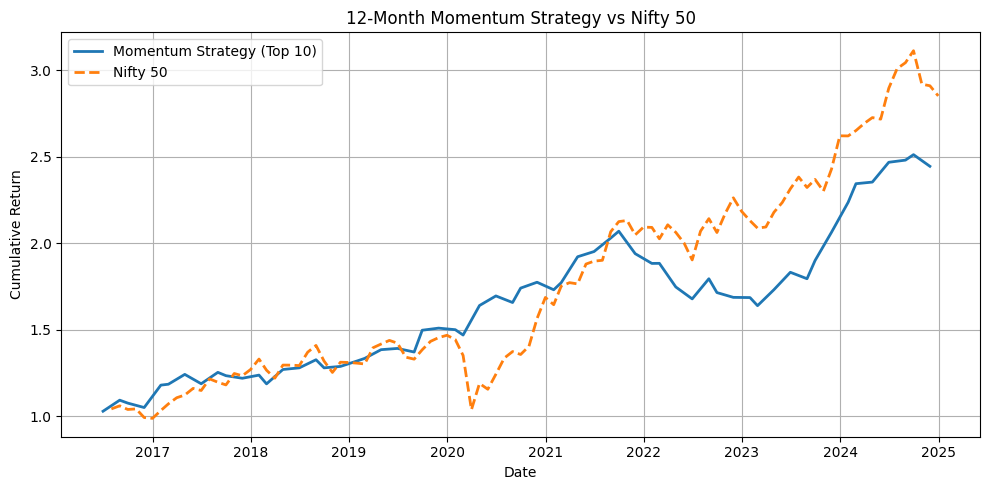

In [28]:
# # Cumulative returns
backtest_df['Cumulative'] = (1 + backtest_df['Return']).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(backtest_df.index, backtest_df['Cumulative'], label='Momentum Strategy (Top 10)', linewidth=2)
plt.plot(nifty_cumulative.index, nifty_cumulative,label='Nifty 50',linestyle='--', linewidth=2)

plt.title("12-Month Momentum Strategy vs Nifty 50")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
cum = backtest_df['Cumulative']
rets = backtest_df['Return']




In [30]:
cum_index = nifty_cumulative['^NSEI']
rets_index = nifty_returns['^NSEI']



In [31]:
vol_12m = returns.rolling(window=12).std()


In [32]:
results = []

for date, row in tqdm(df_month_end.iterrows(), total=len(df_month_end)):
    constituents = row['Constituents']
    
    if date not in roc_12m.index:
        continue

    roc_values = roc_12m.loc[date, constituents].dropna()
    vol_vals = vol_12m.loc[date, constituents].dropna()

    score = roc_values / vol_vals

    top_n = score.sort_values(ascending=False).head(no_of_stocks)
    # top_10 = roc_values.sort_values(ascending=False).head(no_of_stocks)

    for stock in top_10.index:
        results.append({
            'Date': date,
            'Stock': stock,
            'ROC_12M': top_10[stock]
        })


100%|██████████| 106/106 [00:00<00:00, 672.31it/s]


In [33]:
top10_volatility_df = pd.DataFrame(results)

In [34]:
returns = monthly_prices_df.pct_change()

portfolio_returns = []

for date in top10_volatility_df['Date'].unique():
    stocks = top10_volatility_df[top10_volatility_df['Date'] == date]['Stock'].tolist()
    next_month = date + pd.DateOffset(months=1)

    if next_month not in returns.index:
        continue
    
    # Equal-weighted average return
    monthly_return = returns.loc[next_month, stocks].mean()
    
    portfolio_returns.append({
        'Date': next_month,
        'Return': monthly_return
    })

vol_df = pd.DataFrame(portfolio_returns).set_index('Date')


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20124\1661814228.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = monthly_prices_df.pct_change()


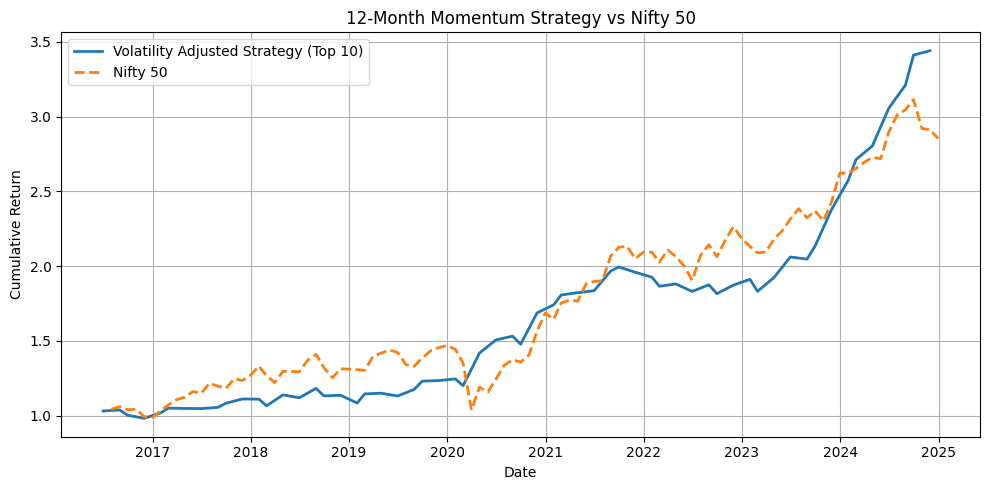

In [35]:
# # Cumulative returns
vol_df['Cumulative'] = (1 + vol_df['Return']).cumprod()


plt.figure(figsize=(10, 5))
plt.plot(vol_df.index, vol_df['Cumulative'], label='Volatility Adjusted Strategy (Top 10)', linewidth=2)
plt.plot(nifty_cumulative.index, nifty_cumulative,label='Nifty 50',linestyle='--', linewidth=2)

plt.title("12-Month Momentum Strategy vs Nifty 50")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
cum_vol = vol_df['Cumulative']
rets_vol = vol_df['Return']




In [37]:
print("CAGR")
print("Index:", calculate_cagr(cum_index))
print("Price Momentum:", calculate_cagr(cum))
print("Volatility Adjusted:", calculate_cagr(cum_vol))

CAGR
Index: 0.13120385807726387
Price Momentum: 0.11207387781756273
Volatility Adjusted: 0.15808493772852072


In [38]:
print("Max Drawdown")
print("Index:", max_drawdown(cum_index))
print("Price Momentum:", max_drawdown(cum))
print("Volatility Adjusted:", max_drawdown(cum_vol))


Max Drawdown
Index: 0.29343919217321507
Price Momentum: 0.2080821804554138
Volatility Adjusted: 0.08963894496702346


In [39]:

print("Annual Volatility")
print("Price Momentum:", annual_volatility(rets))
print("Volatility Adjusted:", annual_volatility(rets_vol))
print("Index:", annual_volatility(rets_index))


Annual Volatility
Price Momentum: 0.15130131784613118
Volatility Adjusted: 0.1574665610514361
Index: 0.16314954022098482


In [40]:

print("Sharpe Ratio")
print("Volatility Adjusted:", sharpe_ratio(rets_vol))
print("Price Momentum:", sharpe_ratio(rets))
print("Index:", sharpe_ratio(rets_index))


Sharpe Ratio
Volatility Adjusted: 1.3419815181012473
Price Momentum: 0.933164802294596
Index: 0.5366842684930829


In [41]:

print("Sortino Ratio")
print("Price Momentum:", sortino_ratio(rets))
print("Volatility Adjusted:", sortino_ratio(rets_vol))
print("Index:", sortino_ratio(rets_index))


Sortino Ratio
Price Momentum: 2.183682111647904
Volatility Adjusted: 3.7124433942679858
Index: 0.6909522691555738


In [42]:

print("Calmar Ratio")
print("Price Momentum:", calmar_ratio(cum))
print("Volatility Adjusted:", calmar_ratio(cum_vol))
print("Index:", calmar_ratio(cum_index))

Calmar Ratio
Price Momentum: 0.5386039187607274
Volatility Adjusted: 1.763574278865925
Index: 0.44712452043493617
